In [1]:
import requests
import tqdm
import h5py

import os

import matplotlib.pyplot as plt

import time

import multiprocessing as mp


In [2]:
baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key":"f96eabbae6f336408a63f875f8cce22f"}

In [3]:
def get(path, params=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically
    return r

def get_save(path, fname, params=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

#     if r.headers['content-type'] == 'application/json':
#         return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
#         filename = r.headers['content-disposition'].split("filename=")[1]
        with open(fname, 'wb') as f:
            f.write(r.content)
        return fname# return the filename string

    return r

In [8]:
sim = get(baseUrl + 'TNG50-1/')

In [9]:
snaps = get(sim['snapshots'])

In [10]:
redshifts = [x['redshift'] for x in snaps]
redshifts = np.flip(redshifts)

In [11]:
num_snapshots = sim['num_snapshots']
print(f'num snapshots = {num_snapshots}')

num_files_snapshot = sim['num_files_snapshot']
print(f'num files snapshots = {num_files_snapshot}')

num snapshots = 100
num files snapshots = 680


# Find the galaxy clusters at z = 0

Find the galaxy clusters ($M_{200}$ $\geq$ 1e13)

In [36]:
url = 'http://www.tng-project.org/api/TNG50-1/files/groupcat-99/'
query_mass = '?Group=Group_M_TopHat200'

get_save(url + query_mass, './initial/Group_M_TopHat200')
print('initial Group_M_TopHat200 saved')

query_firstsub = '?Group=GroupFirstSub'
get_save(url + query_firstsub, './initial/GroupFirstSub')
print('initial GroupFirstSub saved')


query_nsub = '?Group=GroupNsubs'
get_save(url + query_nsub, './initial/GroupNsubs')
print('initial GroupNsubs saved')

initial Group_M_TopHat200 saved
initial GroupFirstSub saved
initial GroupNsubs saved


In [37]:
with h5py.File('./initial/Group_M_TopHat200', 'r') as f:
    M200 = f['Group']['Group_M_TopHat200'][:] * 1e10 / 0.704

In [39]:
cl_index = np.where(M200 >= 1e13)[0]

In [47]:
with h5py.File('./initial/GroupFirstSub', 'r') as f:
    firstsub = f['Group']['GroupFirstSub'][:][cl_index]
    
with h5py.File('./initial/GroupNsubs', 'r') as f:
    nsub = f['Group']['GroupNsubs'][:][cl_index]

In [58]:
if not os.path.exists('./snaps/'):
    
    os.mkdir('./snaps/')
    
for i in tqdm.trange(100):
    
    path_name = f'./snaps/snap{i}'
    
    if not os.path.exists(path_name):
        os.mkdir(path_name)

100%|██████████| 100/100 [00:00<00:00, 1566.43it/s]


In [60]:
for i in tqdm.trange(100):
    
    url = f'http://www.tng-project.org/api/TNG50-1/files/groupcat-{i}/'
    path_name = f'./snaps/snap{i}/'
    
    query_mass = '?Group=Group_M_TopHat200'
    get_save(url + query_mass, path_name + 'Group_M_TopHat200')

    query_firstsub = '?Group=GroupFirstSub'
    get_save(url + query_firstsub, path_name + 'GroupFirstSub')

    query_nsub = '?Group=GroupNsubs'
    get_save(url + query_nsub, path_name + 'GroupNsubs')


100%|██████████| 100/100 [3:42:23<00:00, 133.44s/it] 


In [61]:
cl_index 

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25])

# Find the progenitor cluster

In [252]:
firstsub[cl_index] # Main progenitor of FOF group at z = 0

array([     0,  63864,  96762, 117250, 143880, 167392, 184931, 198182,
       208811, 220595, 229933, 242788, 253861, 264883, 275545, 282779,
       289385, 294866, 300903, 307485, 313692, 319730, 324123, 329508,
       333424, 338446], dtype=int32)

In [262]:
for cl_id in tqdm.tqdm(cl_index):
    
    path = f'./groups/grp{cl_id:02d}'
    
    if not os.path.exists(path):
        os.mkdir(path)

100%|██████████| 26/26 [00:00<00:00, 1235.24it/s]


## Find main progenitor branch and Check the evolution of halo group

Discussion Forum => refer "Halo Evolution"

In [263]:
# find main progenitor branch
for cl_id in tqdm.tqdm(cl_index):
    
    main_sh = firstsub[cl_id]
    
    url = f'http://www.tng-project.org/api/TNG50-1/snapshots/99/subhalos/' + str(main_sh) + '/lhalotree/mpb.hdf5'
    
    fname = f'./groups/grp{cl_id:02d}/lhalompb'
    
    fname = get_save(url, fname)

100%|██████████| 26/26 [45:57<00:00, 106.05s/it]


In [265]:
#check 'SnapNum' and 'SubhaloGrNr'
SnapNums = []
SubhaloGrNrs = []

for cl_id in tqdm.tqdm(cl_index):
    
#     main_sh = firstsub[cl_id]
#     url = f'http://www.tng-project.org/api/TNG50-1/snapshots/99/subhalos/' + str(main_sh) + '/lhalotree/mpb.hdf5'
    
    fname = f'./groups/grp{cl_id:02d}/lhalompb'
    
    with h5py.File(fname, 'r') as f:
        SnapNums.append(f['SnapNum'][:])
        SubhaloGrNrs.append(f['SubhaloGrNr'][:])

100%|██████████| 26/26 [00:00<00:00, 55.65it/s]


In [123]:
Mhalos = []

for cl_id in tqdm.tqdm(cl_index[:1]):    
    
    Mhalo_cl = []
    
    for i, snap in enumerate(SnapNums[cl_id]):
        fname = f'./snaps/snap{snap}/Group_M_TopHat200'
        
        with h5py.File(fname, 'r') as f:
            m200 = f['Group']['Group_M_TopHat200'][:][SubhaloGrNrs[cl_id][i]]
            
        Mhalo_cl.append(m200)
        
    Mhalos.append(np.array(Mhalo_cl))
    
Mhalos = np.array(Mhalos)

100%|██████████| 1/1 [00:14<00:00, 14.14s/it]


In [124]:
Mhalos = Mhalos * 1e10 / 0.704

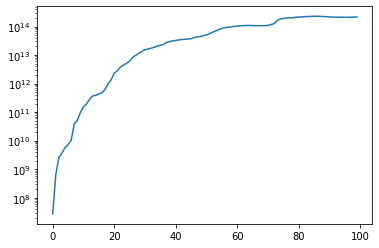

In [125]:
for i in range(1):
    plt.plot(SnapNums[i], Mhalos[i])
    
plt.yscale('log')

In [128]:
np.log10(Mhalos[0])

array([14.333331 , 14.332258 , 14.3288965, 14.32464  , 14.324173 ,
       14.324899 , 14.326714 , 14.328746 , 14.332033 , 14.336003 ,
       14.34371  , 14.352025 , 14.356886 , 14.360477 , 14.360439 ,
       14.354637 , 14.349657 , 14.344896 , 14.337924 , 14.330525 ,
       14.326482 , 14.300474 , 14.310211 , 14.298566 , 14.281098 ,
       14.264148 , 14.206201 , 14.100277 , 14.0698595, 14.03882  ,
       14.031725 , 14.030445 , 14.030041 , 14.027892 , 14.032872 ,
       14.038077 , 14.036871 , 14.0321045, 14.022692 , 14.013137 ,
       14.003033 , 13.988409 , 13.977542 , 13.957794 , 13.93477  ,
       13.895257 , 13.845423 , 13.800451 , 13.749428 , 13.705341 ,
       13.677596 , 13.651607 , 13.636085 , 13.611134 , 13.574371 ,
       13.564708 , 13.5539   , 13.545881 , 13.530735 , 13.509842 ,
       13.496352 , 13.468048 , 13.445096 , 13.370831 , 13.343598 ,
       13.315887 , 13.272157 , 13.240857 , 13.212638 , 13.18712  ,
       13.127692 , 13.064882 , 12.990174 , 12.91625  , 12.7912

# Download the surrounding subhalos (within 10Mpc)

In [7]:
for i in tqdm.trange(100):
    
    url = f'http://www.tng-project.org/api/TNG50-1/files/groupcat-{i}/'
    path_name = f'./snaps/snap{i}/'
    
    query_pos = '?Group=GroupPos'
    get_save(url + query_pos, path_name + 'GroupPos')

100%|██████████| 100/100 [1:42:07<00:00, 61.28s/it]


In [17]:
cl_index = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25])

In [18]:
#check 'SnapNum' and 'SubhaloGrNr'
SnapNums = []
SubhaloGrNrs = []

for cl_id in tqdm.tqdm(cl_index):
    
#     main_sh = firstsub[cl_id]
#     url = f'http://www.tng-project.org/api/TNG50-1/snapshots/99/subhalos/' + str(main_sh) + '/lhalotree/mpb.hdf5'
    
    fname = f'./groups/grp{cl_id:02d}/lhalompb'
    
    with h5py.File(fname, 'r') as f:
        SnapNums.append(f['SnapNum'][:])
        SubhaloGrNrs.append(f['SubhaloGrNr'][:])

100%|██████████| 26/26 [00:00<00:00, 482.25it/s]


In [11]:
# SnapNums

In [19]:
# GroupPos = []

# for cl_id in tqdm.tqdm(cl_index):    
    
#     GroupPos_cl = []
    
#     for i, snap in enumerate(SnapNums[cl_id]):
#         fname = f'./snaps/snap{snap}/GroupPos'
        
#         with h5py.File(fname, 'r') as f:
#             pos = f['Group']['GroupPos'][:][SubhaloGrNrs[cl_id][i]]
            
#         GroupPos_cl.append(pos)
        
#     GroupPos.append(np.array(GroupPos_cl))
    
# GroupPos = np.array(GroupPos)


GroupPos_cl = []
for i, snap in enumerate(SnapNums[0]):
    fname = f'./snaps/snap{snap}/GroupPos'

    with h5py.File(fname, 'r') as f:
        pos = f['Group']['GroupPos'][:][SubhaloGrNrs[0][i]]

    GroupPos_cl.append(pos)
    
GroupPos_cl = np.array(GroupPos_cl)

In [8]:
SnapNums[0]

array([99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83,
       82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66,
       65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49,
       48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32,
       31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15,
       14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0],
      dtype=int32)

In [16]:
path = '/data3/ehko/illustris/snaps/'

for snap in tqdm.trange(100):

    os.mkdir(path + f'snap{snap:02d}')

100%|██████████| 100/100 [00:00<00:00, 339.33it/s]


In [12]:
url = f'http://www.tng-project.org/api/TNG50-1/snapshots/99/subhalos/' 

scale_factor = 1 / (1 + redshifts)
little_h = 0.704


# GroupPos_cl *= scale_factor[0] / little_h # ckpc/h -> physical kpc

In [31]:
# redshifts

In [32]:
distance = 10000 / scale_factor[0] * little_h # physcial kpc -> ckpc/h

In [33]:
distance

7040.000000000001

In [34]:
1/ scale_factor[-1] * little_h

14.816729656120478

In [37]:
search_query = f'?pos_x__gt={GroupPos_cl[0][0] - distance}&pos_x__lt={GroupPos_cl[0][0] + distance}&pos_y__gt={GroupPos_cl[0][1] - distance}&pos_y__lt={GroupPos_cl[0][1] + distance}&pos_z__gt={GroupPos_cl[0][2] - distance}&pos_z__lt={GroupPos_cl[0][2] + distance}'

# search_query = f'?pos_x__gt={GroupPos_cl[0][0] - distance}&pos_x__lt={GroupPos_cl[0][0] + distance}&pos_y__gt={GroupPos_cl[0][1] - distance}&pos_y__lt={GroupPos_cl[0][1] + distance}'

In [38]:
get(url+search_query)

{'count': 675706,
 'next': 'http://www.tng-project.org/api/TNG50-1/snapshots/99/subhalos/?limit=100&offset=100&pos_x__gt=267.2407226562491&pos_x__lt=14347.24072265625&pos_y__gt=17510.361328125&pos_y__lt=31590.361328125&pos_z__gt=14262.580078125&pos_z__lt=28342.580078125',
 'previous': None,
 'results': [{'id': 0,
   'sfr': 1.15783,
   'mass_log_msun': 14.292666717121172,
   'url': 'http://www.tng-project.org/api/TNG50-1/snapshots/99/subhalos/0/'},
  {'id': 1,
   'sfr': 0.0,
   'mass_log_msun': 12.398219446940564,
   'url': 'http://www.tng-project.org/api/TNG50-1/snapshots/99/subhalos/1/'},
  {'id': 2,
   'sfr': 0.000985458,
   'mass_log_msun': 12.365220400807692,
   'url': 'http://www.tng-project.org/api/TNG50-1/snapshots/99/subhalos/2/'},
  {'id': 3,
   'sfr': 0.0,
   'mass_log_msun': 11.697131232640892,
   'url': 'http://www.tng-project.org/api/TNG50-1/snapshots/99/subhalos/3/'},
  {'id': 4,
   'sfr': 0.0,
   'mass_log_msun': 11.441590549818002,
   'url': 'http://www.tng-project.org/

In [ ]:
subhalos = []

path = url + search_query

for _ in tqdm.trange(6757):

    while True:

        try:

            results = get(path)
        except:

            time.sleep(3)
#             results = get(path)
        else:
            break    
    
    subs = results['results']
    subs = [x['id'] for x in subs]
    
    subhalos.extend(subs)
    
    if results['next'] == None:
        break
    
    path = results['next']

 40%|████      | 2726/6757 [1:58:49<3:36:51,  3.23s/it]

In [113]:
len(subhalos)

675706

In [119]:
cutout_query = {'gas':'Coordinates,Density,Masses,ParticleIDs,InternalEnergy'}

In [136]:
keys = ['pos_x', 'pos_y', 'pos_z', 'len_gas', 'len_stars', 'mass', 'mass_gas', 'mass_stars', 'sfr', 'primary_flag']

In [210]:
def load_sub_info(subid):
    
    path = f'/data3/ehko/illustris/snaps/snap99/sub{subid}.hdf5'
    
    if os.path.exists(path):
        return
    
    url = f'http://www.tng-project.org/api/TNG50-1/snapshots/99/subhalos/{subid}/'
    
    while True:
        try:
            result = get(url)
            

        except:
            print(subid, end = ' ')
            time.sleep(np.random.random())
            continue
            
        else:
            break
    
    with h5py.File(path, 'w') as f:
        
        for key in keys:
            f.attrs[key] = result[key]
    
#     result['pos_x'], result['pos_y'], result['pos_z'], result['len_gas'], result['len_star'], result['mass'], result['mass_gas'], result['mass_star'], result['sfr'], result['primary_flag']

In [214]:
n = 20 #number of cores to use
with mp.Pool(n) as p:
    
    for _ in tqdm.tqdm(p.imap_unordered(load_sub_info, subhalos), total = len(subhalos)):
        pass
    

In [207]:
np.random.randint(1, 10)

3

In [193]:
# result

In [177]:
subhalos[2783]

2783

In [182]:
url = f'http://www.tng-project.org/api/TNG50-1/snapshots/99/subhalos/8414/'

result = get(url)

In [183]:
result

{'snap': 99,
 'id': 8414,
 'bhmdot': 0.0,
 'cm_x': 7687.83,
 'cm_y': 23850.4,
 'cm_z': 21519.9,
 'gasmetallicity': 0.0,
 'gasmetallicityhalfrad': 0.0,
 'gasmetallicitymaxrad': 0.0,
 'gasmetallicitysfr': 0.0,
 'gasmetallicitysfrweighted': 0.0,
 'pos_x': 7687.88,
 'pos_y': 23850.2,
 'pos_z': 21520.0,
 'halfmassrad': 1.27,
 'halfmassrad_gas': 0.0,
 'halfmassrad_dm': 1.27,
 'halfmassrad_stars': 0.0,
 'halfmassrad_bhs': 0.0,
 'len': 290,
 'len_gas': 0,
 'len_dm': 290,
 'len_stars': 0,
 'len_bhs': 0,
 'mass': 0.008914,
 'mass_gas': 0.0,
 'mass_dm': 0.008914,
 'mass_stars': 0.0,
 'mass_bhs': 0.0,
 'massinhalfrad': 0.0,
 'massinhalfrad_gas': 0.0,
 'massinhalfrad_dm': 0.0,
 'massinhalfrad_stars': 0.0,
 'massinhalfrad_bhs': 0.0,
 'massinmaxrad': 0.004365,
 'massinmaxrad_gas': 0.0,
 'massinmaxrad_dm': 0.004365,
 'massinmaxrad_stars': 0.0,
 'massinmaxrad_bhs': 0.0,
 'massinrad': 0.0,
 'massinrad_gas': 0.0,
 'massinrad_dm': 0.0,
 'massinrad_stars': 0.0,
 'massinrad_bhs': 0.0,
 'sfr': 0.0,
 'sfrinha

In [ ]:
pos_xs = []
pos_ys = []
pos_zs = []

len_gases = []
len_stars = []

masses = []
mass_gases = []
mass_stars = []

sfrs = []
primary_flags = []


In [121]:
np.log10(13289.6 * 1e10 / little_h)

14.275939250287673

In [92]:
temp2['len_stars']

{'snap': 99,
 'id': 0,
 'bhmdot': 0.000185235,
 'cm_x': 7300.43,
 'cm_y': 24514.0,
 'cm_z': 21300.2,
 'gasmetallicity': 0.00954238,
 'gasmetallicityhalfrad': 0.011177,
 'gasmetallicitymaxrad': 0.0,
 'gasmetallicitysfr': 0.00758403,
 'gasmetallicitysfrweighted': 0.00803236,
 'pos_x': 7307.24,
 'pos_y': 24550.4,
 'pos_z': 21302.6,
 'halfmassrad': 362.23,
 'halfmassrad_gas': 383.195,
 'halfmassrad_dm': 371.711,
 'halfmassrad_stars': 29.2812,
 'halfmassrad_bhs': 0.0,
 'len': 718577369,
 'len_gas': 254750400,
 'len_dm': 369615124,
 'len_stars': 94211842,
 'len_bhs': 3,
 'mass': 13289.6,
 'mass_gas': 1559.96,
 'mass_dm': 11360.8,
 'mass_stars': 368.293,
 'mass_bhs': 0.579029,
 'massinhalfrad': 407.339,
 'massinhalfrad_gas': 3.09503,
 'massinhalfrad_dm': 219.518,
 'massinhalfrad_stars': 184.146,
 'massinhalfrad_bhs': 0.578949,
 'massinmaxrad': 0.001185,
 'massinmaxrad_gas': 0.0,
 'massinmaxrad_dm': 3.1e-05,
 'massinmaxrad_stars': 0.001154,
 'massinmaxrad_bhs': 0.0,
 'massinrad': 894.026,
 'ma

In [116]:
temp3 = get('http://www.tng-project.org/api/TNG50-1/snapshots/99/subhalos/0/info.json')

In [117]:
temp3

{'SimulationName': 'L35n2160TNG',
 'SnapshotNumber': 99,
 'InfoType': 'Subhalo',
 'InfoID': 0,
 'StarFormationRates': {'Done': 1.0,
  'SFR_MsunPerYrs_in_InRad_1000Myrs': 0.2790251519457446,
  'SFR_MsunPerYrs_in_InRad_100Myrs': 0.27163445898786,
  'SFR_MsunPerYrs_in_InRad_10Myrs': 0.12573216628521677,
  'SFR_MsunPerYrs_in_InRad_200Myrs': 0.3788171115495894,
  'SFR_MsunPerYrs_in_InRad_50Myrs': 0.1971252036787364,
  'SFR_MsunPerYrs_in_all_1000Myrs': 1.1166861188993296,
  'SFR_MsunPerYrs_in_all_100Myrs': 1.2036251774757543,
  'SFR_MsunPerYrs_in_all_10Myrs': 1.1216120295419476,
  'SFR_MsunPerYrs_in_all_200Myrs': 1.2023580065955042,
  'SFR_MsunPerYrs_in_all_50Myrs': 1.1613595026906225,
  'SFR_MsunPerYrs_in_r30pkpc_1000Myrs': 0.05817212994851763,
  'SFR_MsunPerYrs_in_r30pkpc_100Myrs': 0.10756522128225637,
  'SFR_MsunPerYrs_in_r30pkpc_10Myrs': 0.07933336564854561,
  'SFR_MsunPerYrs_in_r30pkpc_200Myrs': 0.09771155410477081,
  'SFR_MsunPerYrs_in_r30pkpc_50Myrs': 0.10336227561762733,
  'SFR_MsunP

**sublink_simple**

retrieve a simple representation of the SubLink tree, the Main Progenitor Branch (in 'Main') and a list of past mergers (in 'Mergers') only. In both cases a snapshot number and subhalo ID pair is given.

In [121]:
sub['trees']

{'sublink': 'http://www.tng-project.org/api/TNG50-1/snapshots/99/subhalos/0/sublink/full.hdf5',
 'sublink_mpb': 'http://www.tng-project.org/api/TNG50-1/snapshots/99/subhalos/0/sublink/mpb.hdf5',
 'sublink_mdb': 'http://www.tng-project.org/api/TNG50-1/snapshots/99/subhalos/0/sublink/mdb.hdf5',
 'sublink_simple': 'http://www.tng-project.org/api/TNG50-1/snapshots/99/subhalos/0/sublink/simple.json',
 'lhalotree': 'http://www.tng-project.org/api/TNG50-1/snapshots/99/subhalos/0/lhalotree/full.hdf5',
 'lhalotree_mpb': 'http://www.tng-project.org/api/TNG50-1/snapshots/99/subhalos/0/lhalotree/mpb.hdf5'}

In [192]:
submpb = get_save(sub['trees']['sublink_mpb'], 'sublink_mpb')

In [195]:
submpb = h5py.File('sublink_mpb')

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


In [196]:
submpb.keys()

<KeysViewHDF5 ['DescendantID', 'FirstProgenitorID', 'FirstSubhaloInFOFGroupID', 'GroupBHMass', 'GroupBHMdot', 'GroupCM', 'GroupFirstSub', 'GroupGasMetalFractions', 'GroupGasMetallicity', 'GroupLen', 'GroupLenType', 'GroupMass', 'GroupMassType', 'GroupNsubs', 'GroupPos', 'GroupSFR', 'GroupStarMetalFractions', 'GroupStarMetallicity', 'GroupVel', 'GroupWindMass', 'Group_M_Crit200', 'Group_M_Crit500', 'Group_M_Mean200', 'Group_M_TopHat200', 'Group_R_Crit200', 'Group_R_Crit500', 'Group_R_Mean200', 'Group_R_TopHat200', 'LastProgenitorID', 'MainLeafProgenitorID', 'Mass', 'MassHistory', 'NextProgenitorID', 'NextSubhaloInFOFGroupID', 'NumParticles', 'RootDescendantID', 'SnapNum', 'SubfindID', 'SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloCM', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'Subh

In [246]:
submpb['SnapNum'][:]

array([99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83,
       82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66,
       65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49,
       48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32,
       31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15,
       14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0],
      dtype=int16)

In [247]:
submpb['SubhaloGrNr'][:]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         2,   1,   2,   2,   2,   2,   2,   2,   2,   1,   1,   2,   2,
         2,   2,   2,   2,   3,   2,   7,  11,  11,  10,   8,   7,   7,
         6,   6,   7,   9,  77, 278, 276, 768, 743], dtype=int32)

In [226]:
# submpb['TreeID'][:]

In [223]:
submpb['SubfindID'][:]
# submpb['SubhaloID'][:]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     2,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0, 15511,
       15404, 15624, 15693, 15268, 15472, 15216, 15220, 15195,  9247,
        8857,  8266, 15343,  8068, 14355, 13700, 13673, 13021,  9440,
       10323,  8987,  3769,  3258,  5996,  4230,  3857,  3618,  3738,
        2918,  3119,  1836,  4458,  4301,  4308,  3400,  2314,  2120,
        2017,  1470,  1393,  1317,  1329,  3971,  6134,  4334,  3853,
        1171], dtype=int32)

In [198]:
lhalompb = get_save(sub['trees']['lhalotree_mpb'], 'lhalotree_mpb')

In [232]:
lhalompb = h5py.File('lhalotree_mpb', 'r')

In [201]:
lhalompb.keys()

<KeysViewHDF5 ['Descendant', 'FileNr', 'FirstHaloInFOFGroup', 'FirstProgenitor', 'GroupCM', 'GroupMassType', 'Group_M_Crit200', 'Group_M_Crit500', 'Group_M_Mean200', 'Group_M_TopHat200', 'Group_R_Crit200', 'Group_R_Crit500', 'Group_R_Mean200', 'Group_R_TopHat200', 'NextHaloInFOFGroup', 'NextProgenitor', 'SnapNum', 'SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetallicity', 'SubhaloGasMetallicitySfr', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostBound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloNumber', 'SubhaloOffsetType', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetallicity', 'SubhaloStellarPhotometrics', 'SubhaloVMax', 'SubhaloVel', 'SubhaloVelDisp']>

In [234]:
# lhalompb['SnapNum'][:]

In [214]:
lhalompb['FileNr'][:]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, 10,  9,  9,  9,  9,  9,  8,  8,  8,  5,  5,  5,  9,  4,  8,
        7,  7,  6,  5,  5,  4,  2,  1,  2,  2,  1,  1,  1,  1,  1,  0,  1,
        1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  3, 13],
      dtype=int32)

In [145]:
mpb = get_save(sub['trees']['lhalotree_mpb'], 'lhalotree_mpb')

In [146]:
mpb = h5py.File('lhalotree_mpb')

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


In [190]:
mpb.keys()

<KeysViewHDF5 ['Descendant', 'FileNr', 'FirstHaloInFOFGroup', 'FirstProgenitor', 'GroupCM', 'GroupMassType', 'Group_M_Crit200', 'Group_M_Crit500', 'Group_M_Mean200', 'Group_M_TopHat200', 'Group_R_Crit200', 'Group_R_Crit500', 'Group_R_Mean200', 'Group_R_TopHat200', 'NextHaloInFOFGroup', 'NextProgenitor', 'SnapNum', 'SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetallicity', 'SubhaloGasMetallicitySfr', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostBound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloNumber', 'SubhaloOffsetType', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetallicity', 'SubhaloStellarPhotometrics', 'SubhaloVMax', 'SubhaloVel', 'SubhaloVelDisp']>

In [189]:
mpb['SnapNum'][:]

array([99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83,
       82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66,
       65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49,
       48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32,
       31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15,
       14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0],
      dtype=int32)

In [228]:
mpb['FirstHaloInFOFGroup'][:]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype=int32)

In [126]:
temp = get(sub['trees']['sublink_simple']) #Main, Merger

In [251]:
# sub['trees']['sublink_simple']

In [140]:
temp2 = np.array(temp['Mergers'])

In [175]:
temp2[(temp2[:, 0] == 98) & (temp2[:, 1] == 0)]

array([], shape=(0, 2), dtype=int64)

In [ ]:
for i in range(100)

    # request the full subhalo details of the descendant by following the sublink URL
    sub = get(sub['related']['sublink_projenitor'])

In [ ]:
#find halos whose masses are greater than 14.
# link the halos in the direction of redshift
# check gas, star-forming galxy distribution

#reference: IllustriTNG-50 page